In [1]:
# core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join as pjoin

from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 500

In [2]:
data_path = pjoin('..', 'data')
df_train = pd.read_csv(pjoin(data_path, 'train_eng.csv'), engine='c')
df_test = pd.read_csv(pjoin(data_path, 'test_eng.csv'), engine='c')

# ignore_index from previous savings
#df_train = df_train[df_train.columns[1:]]
#df_test = df_test[df_test.columns[1:]]

In [3]:
for df in [df_train, df_test]:
    df['StartOfferDate'] = pd.to_datetime(df['StartOfferDate'])
    df['StartDateCorrection'] = pd.to_datetime(df['StartDateCorrection'], 
                                               errors='coerce')
    df['EndDate'] = pd.to_datetime(df['EndDate'])
    df['EndOfferDate'] = pd.to_datetime(df['EndOfferDate'])

In [4]:
df_train['train_val'] = np.where(
    (df_train.EndDate > "2017-06-30")  
    & (df_train.LotStatus == 'Завершено лот закупівлі') 
    & (df_train.TenderStatus=='complete'), 
    'val', 
    'train'
)

In [5]:
df_train.set_index('unique_id', inplace=True)
df_test.set_index('unique_id', inplace=True)

df_train = df_train[[c for c in df_train.columns if c in df_test.columns] + ['train_val']]

df_train_grouped = df_train.groupby(df_train.index).head(1).sort_index()
df_train_grouped['counts'] = df_train.groupby(df_train.index).size().sort_index()

## Geo + Categorical

In [6]:
# encode categorical features INPLACE!
def __encode_categorical(df_list, cat_cols):
    # encode categorical data
    d = defaultdict(LabelEncoder)

    # fit and encode train/test
    a = pd.concat([df[cat_cols] for df in df_list], axis=0).fillna('').apply(
        lambda x: d[x.name].fit(x))
    # transform encodings to train/test
    for df in df_list:
        df[cat_cols] = df[cat_cols].fillna('').apply(lambda x: d[x.name].transform(x))

        
# example usage:
# features_categorigal = ['TypeOrginizer', 'TypeMethod']
# encode_categorical(df_list, features_categorigal)
        

# GEO FEATURES -------------------------------------------------

# create mapping dict
geo_mapping_coord = pd.DataFrame(
{ 
    # '6 chars lowercased': (LabelEncoder ID, lat, long)
    'київсь':     (1, 50.4021368,30.2525113),
    'дніпро':     (2, 48.4624412,34.8602734),
    'донець':     (3, 47.9902621,37.6214375),
    'вінниц':     (4, 49.2348249,28.3995942),
    'запорі':     (5, 47.8563742,35.0352705),
    'львівс':     (6, 49.8327787,23.9421959),
    'черніг':     (7, 51.495866,31.2204989),
    'одеськ':      (8, 46.460123,30.5717042),
    'харків':      (9, 49.9947277,36.1457419),
    'житоми':      (10, 50.2679751,28.6036779),
    'микола':      (11, 46.9332135,31.8679138),
    'сумськ':      (12, 50.9007528,34.7441743),
    'волинс':      (13, 50.7398786,25.2639652),
    'полтав':      (14, 49.6021346,34.4871989),
    'хмельн':      (15, 49.4106425,26.9252189),
    'івано-':      (16, 48.9118242,24.6821096),
    'черкас':      (17, 49.4312235,31.9791903),
    'рівнен':      (18, 50.6111564,26.1745436),
    'луганс':      (19, 48.5802062,39.2168845),
    'терноп':      (20, 49.5484448,25.5276293),
    'херсон':      (21, 46.6496689,32.5377419),
    'кірово':      (22, 48.518858,32.1456233),
    'чернів':      (23, 51.495866,31.2204989),
    'закарп':      (24, 48.496582,22.8212266),
    'украин':      (25, 48.2559613,26.6958946),# украина
    'відпов':      (26, 0, 0),# відповідно документу
    'others':       (-1, 0, 0), # missing / other
}).T

geo_mapping_coord.columns = ['LabelEncoderID', 'lat', 'long']


# pass grouped (train/test) dataframes
# geo_mapping_df == geo_mapping_coord
def __create_geo_features(df, geo_mapping_df):
    
    df_geo = df.reset_index()[[
        'unique_id', 
        'DeliveryRegion', 
        'OrgRegion'
    ]].copy(deep=True)
    
    
    # 1. DeliveryRegion
    # clean some garbage (heuristics)

    # strip and lowercase, take 6 first chars
    df_geo.loc[df_geo.DeliveryRegion == '-', 'DeliveryRegion'] = 'others'
    df_geo.DeliveryRegion = df_geo.DeliveryRegion.str.strip()\
    .str.lower().str[:6]

    df_geo.loc[df_geo.DeliveryRegion == 'одесск', 
                         'DeliveryRegion'] = 'одеськ'
    df_geo.loc[df_geo.DeliveryRegion == 'украин', 
                         'DeliveryRegion'] = 'україн'

    df_geo.loc[df_geo.DeliveryRegion == 'харько', 
                         'DeliveryRegion'] = 'харків'

    true_regions = set(geo_mapping_df.index.values.tolist())

    # fill-in all other
    df_geo.loc[
        ~df_geo.DeliveryRegion.isin(true_regions), 
        'DeliveryRegion'
    ] = 'others'

    # estimate garbage/missing percent
    print('garbage/missing %: {:.2f}'.format(
        df_geo[df_geo.DeliveryRegion == 'others'].shape[0] / 
        df_geo.shape[0]
    ))
    
    # 2. OrgRegions
    # replace missing and clean data
    df_geo.loc[df_geo.OrgRegion == '-', 'OrgRegion'] = 'others'
    df_geo.OrgRegion = df_geo.OrgRegion.str[:6].str.lower()
    
    # add lat/long
    
    df_geo['OrgRegion_lat'] = df_geo.OrgRegion.map(geo_mapping_df['lat']).fillna(0)
    df_geo['OrgRegion_long'] = df_geo.OrgRegion.map(geo_mapping_df['long']).fillna(0)
    
    df_geo['DeliveryRegion_lat'] = df_geo.DeliveryRegion.map(
        geo_mapping_df['lat']).fillna(0)
    df_geo['DeliveryRegion_long'] = df_geo.DeliveryRegion.map(
        geo_mapping_df['long']).fillna(0)
    
    # cnange strings to label encoded
    df_geo.OrgRegion = df_geo.OrgRegion.map(
        geo_mapping_df['LabelEncoderID']).fillna(-1)
    df_geo.DeliveryRegion = df_geo.DeliveryRegion.map(
        geo_mapping_df['LabelEncoderID']).fillna(-1)
    
    # check is equal
    df_geo['DeliveryOrg_isequal'] = (df_geo.OrgRegion == df_geo.DeliveryRegion)
    
    
    # return distance for non-equal
    df_geo['DeliveryOrg_distance'] = -1
    df_geo.loc[~df_geo.DeliveryOrg_isequal, 'DeliveryOrg_distance'] = \
    df_geo.loc[~df_geo.DeliveryOrg_isequal, 
              ].apply(
        lambda x: np.linalg.norm(
            np.array([x['DeliveryRegion_lat'],x['DeliveryRegion_long']]) 
            - np.array([x['OrgRegion_lat'],x['OrgRegion_long']]))
    , axis=1
    )
    
    return df.drop(['DeliveryRegion', 'OrgRegion'], axis=1, errors='ignore').merge(
            right=df_geo.set_index('unique_id'),
            left_index=True,
            right_index=True
    )


def add_cat_and_geo_features(df_list, cat_cols, geo_mapping_df):
    
    # perform categorical encoding inplace
    __encode_categorical(df_list, cat_cols)
    
    # process geo-features and concat it with the initial df for each df in list
    df_list = [__create_geo_features(df, geo_mapping_df) for df in df_list]
    
    return df_list

## CPV features

In [7]:
def strip(x, n):
    return x.strip()[:n].strip()


def add_CPV_features(df, split_type=2):
    
    df['CPV2017'] = df['CPV2017'].apply(lambda x: '00000000-0'
                                        if strip(x, 10) == '-' else x)

    if split_type == 1:
        df['CPV_unit'] = df['CPV2017'].apply(lambda x: int(x.strip()[:2]))
        df['CPV_group'] = df['CPV2017'].apply(lambda x: int(x.strip()[2:3]))
        df['CPV_class'] = df['CPV2017'].apply(lambda x: int(x.strip()[3:4]))
        df['CPV_cat'] = df['CPV2017'].apply(lambda x: int(x.strip()[4:5]))
    else:
        df['CPV_unit'] = df['CPV2017'].apply(lambda x: int(x.strip()[:2]))
        df['CPV_group'] = df['CPV2017'].apply(lambda x: int(x.strip()[:3]))
        df['CPV_class'] = df['CPV2017'].apply(lambda x: int(x.strip()[:4]))
        df['CPV_cat'] = df['CPV2017'].apply(lambda x: int(x.strip()[:5]))

    df['CPV_desc'] = df['CPV2017'].apply(lambda x: x[11:])
    df['CPV_desc'] = df['CPV_desc'].apply(
        lambda x: "NO DESC" if len(x.strip()) < 2 else x)

    df['Organizer'] = df['Organizer'].apply(lambda x: x.lower())
    df['Organizer_railroad'] = df['Organizer'].apply(
        lambda x: 1 if 'залізниц' in x else 0)
    df['Organizer_ministry'] = df['Organizer'].apply(
        lambda x: 1 if 'міністерств' in x else 0)
    df['Organizer_komun'] = df['Organizer'].apply(
        lambda x: 1 if 'комунальне підприємство'
        in x else 0)
    df['Organizer_edu'] = df['Organizer'].apply(
        lambda x: 1 if 'освіт' in x else 0)

    return df

## Numerical Features

In [8]:
import scipy.stats as spstats

features_numerical = ['GuaranteeValueLot', 'StepDecreaseLot', 'SumTender']


def boxcox_feature(feature_name, df):

    feature_np = np.array(df[feature_name])
    feature_np_clean = feature_np[~np.isnan(feature_np)]
    l, opt_lambda = spstats.boxcox(feature_np_clean)
    df[feature_name+'_0'] = spstats.boxcox(
        (1+df[feature_name]),
        lmbda=0)
    df[feature_name+'_0'] = df[feature_name+'_0'].fillna(0.0)
    df[feature_name+'_boxcox_lambda_opt'] = spstats.boxcox(
        df[feature_name], lmbda=opt_lambda)
    df[feature_name+'_boxcox_lambda_opt'] = df[feature_name +
                                               '_boxcox_lambda_opt'].fillna(0.0)
    return df


# just feed df with eng columns
def transfrom_numerical(df, features_numerical):
    for feature in features_numerical:
        df[feature] = df[feature].apply(pd.to_numeric, errors='coerce')
    df[features_numerical] = df[features_numerical].fillna(0)
    for feature in features_numerical:
        df[feature +
            '_isZero'] = df[feature].apply(lambda x: 1 if x == 0.0 else 0)
    df[features_numerical] = df[features_numerical].replace(0.0, np.nan)
    for feature in features_numerical:
        df = boxcox_feature(feature, df)
    #df = df.drop(columns=features_numerical)
    return df

## Date features

In [9]:
def get_date_features(df, date_columns):
    for c in date_columns:
        df[c + '_year'] = df[c].dt.year
        df[c + '_month'] = df[c].dt.month
        df[c + '_dow'] = df[c].dt.dayofweek
    
    return df

    
# add date features
date_columns = ['StartOfferDate']
for df in [df_train_grouped, df_test]:
    df = get_date_features(df, date_columns)
print(df_train_grouped.shape, df_test.shape)

(500037, 26) (75969, 24)


In [10]:
def get_date_diff(df, date1, date2):
    df[date1+'_diff_'+date2] = (df[date1]-df[date2])/np.timedelta64(1, 'D')
    return df

for df in [df_train_grouped, df_test]:
    df = get_date_diff(df, 'EndOfferDate', 'StartOfferDate' )
    df = get_date_diff(df, 'EndDate', 'StartDateCorrection' )
    df = get_date_diff(df, 'EndDate', 'EndOfferDate' )
    df = get_date_diff(df, 'StartOfferDate', 'StartDateCorrection' )
print(df_train_grouped.shape, df_test.shape)

(500037, 30) (75969, 28)


In [11]:
df_test.columns

Index(['Unnamed: 0', 'CPV2017', 'SumTender', 'Organizer', 'ID', 'IDLOT',
       'StartOfferDate', 'TypeMethod', 'TypeOrginizer', 'LotStatus',
       'TenderStatus', 'OrgRegion', 'DeliveryRegion', 'Tender',
       'StartDateCorrection', 'LotDescr', 'IDOrganizator', 'EndDate',
       'EndOfferDate', 'StepDecreaseLot', 'GuaranteeValueLot',
       'StartOfferDate_year', 'StartOfferDate_month', 'StartOfferDate_dow',
       'EndOfferDate_diff_StartOfferDate', 'EndDate_diff_StartDateCorrection',
       'EndDate_diff_EndOfferDate', 'StartOfferDate_diff_StartDateCorrection'],
      dtype='object')

In [12]:
%%time

# add geo + encode categorical
print(df_train_grouped.shape, df_test.shape)
cat_cols = ['TypeOrginizer', 'TypeMethod']
df_train_grouped, df_test = add_cat_and_geo_features([df_train_grouped, df_test], cat_cols, geo_mapping_coord)
print(df_train_grouped.shape, df_test.shape)

# add cpv features
for df in [df_train_grouped, df_test]:
    df = add_CPV_features(df)
print(df_train_grouped.shape, df_test.shape)

# add and transform numericals
for df in [df_train_grouped, df_test]:
    df = transfrom_numerical(df, features_numerical=features_numerical)
print(df_train_grouped.shape, df_test.shape)

(500037, 30) (75969, 28)
garbage/missing %: 0.02
garbage/missing %: 0.02
(500037, 36) (75969, 34)
(500037, 45) (75969, 43)


/home/dima/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:1030: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


(500037, 54) (75969, 52)
CPU times: user 25.1 s, sys: 520 ms, total: 25.6 s
Wall time: 25.6 s


---

In [13]:
train = df_train_grouped[df_train_grouped.train_val=='train']
val = df_train_grouped[df_train_grouped.train_val=='val']

In [14]:
train['LotStatus'].value_counts()

Завершено лот закупівлі     223891
Неуспішний лот закупівлі    169753
Скасовано лот закупівлі      33134
Активний лот закупівлі       10272
Name: LotStatus, dtype: int64

In [15]:
train['TenderStatus'].value_counts()

complete                                238505
unsuccessful                            155343
cancelled                                32550
active.awarded                            9112
active.qualification                      1464
active.tendering                            53
active.pre-qualification                    18
active.pre-qualification.stand-still         5
Name: TenderStatus, dtype: int64

In [16]:
train = train[train['LotStatus'] == 'Завершено лот закупівлі'][train['TenderStatus'] == 'complete']

/home/dima/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


## Organizators features

In [17]:
organizator_lots_count = dict(train['IDOrganizator'].value_counts())
# organizator_props_count = {}
# organizator_participant_count = {}
# organizator_ratio = {}
# for org_name, org_data in train_small_all.groupby('IDOrganizator'):    
#     organizator_props_count[org_name] = len(org_data)
#     organizator_participant_count[org_name] = len(org_data['Participant'].unique().tolist())
#     organizator_ratio[org_name] = organizator_participant_count[org_name] / organizator_props_count[org_name]

In [18]:
def get_organizator_lots_count(id_organizator):
    if id_organizator in organizator_lots_count:
        return np.log(organizator_lots_count[id_organizator])
    else:
        return 0

In [19]:
train['organizator_lots_count'] = train['IDOrganizator'].map(get_organizator_lots_count)
# train['organizator_props_count'] = train['IDOrganizator'].map(get_organizator_props_count)
# train['organizator_participant_count'] = train['IDOrganizator'].map(get_organizator_participant_count)
# train['organizator_ratio'] = train['IDOrganizator'].map(get_organizator_ratio)
# train['org_complaints'] = train['Organizer'].map(get_org_complaints)
# train['org_complaints_ratio'] = train['org_complaints'].astype('float') / train['organizator_lots_count'].astype('float').fillna(0)


val['organizator_lots_count'] = val['IDOrganizator'].map(get_organizator_lots_count)
# val['organizator_props_count'] = val['IDOrganizator'].map(get_organizator_props_count)
# val['organizator_participant_count'] = val['IDOrganizator'].map(get_organizator_participant_count)
# val['organizator_ratio'] = val['IDOrganizator'].map(get_organizator_ratio)
# val['org_complaints'] = val['Organizer'].map(get_org_complaints)
# val['org_complaints_ratio'] = val['org_complaints'].astype('float') / val['organizator_lots_count'].astype('float').fillna(0)

/home/dima/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [20]:
organiztor_lots_count_test = dict(df_train_grouped['IDOrganizator'].value_counts())
def organizator_popularity_test(id_organizator):
    if id_organizator in organiztor_lots_count_test:
        return np.log(organiztor_lots_count_test[id_organizator])
    else:
        return 0
df_test['organizator_lots_count'] = df_test['IDOrganizator'].map(organizator_popularity_test)

## Text features

In [21]:
## Linear
text_features = pd.read_csv('../data/text_prediction.csv')
text_features_test = pd.read_csv('../data/text_prediction_test.csv')

## NN
text_nn_features = pd.read_csv('../data/text_nn_prediction.csv')
text_nn_features_test = pd.read_csv('../data/text_nn_prediction_test.csv')

In [22]:
train = train.reset_index()
val = val.reset_index()
df_test = df_test.reset_index()

In [23]:
train = train.merge(text_features, on='unique_id')
val = val.merge(text_features, on='unique_id')

In [24]:
train = train.merge(text_nn_features, on='unique_id')
val = val.merge(text_nn_features, on='unique_id')

In [25]:
df_test = df_test.merge(text_features_test, on='unique_id')
df_test = df_test.merge(text_nn_features_test, on='unique_id')

In [26]:
# train['pred_nn_kvadrat'] = train['prediction_text_nn']*train['EndDate_diff_StartDateCorrection']
# train['pred_nn_koob'] = train['prediction_text_nn']*train['TypeMethod']
# val['pred_nn_kvadrat'] = val['prediction_text_nn']*val['EndDate_diff_StartDateCorrection']
# val['pred_nn_koob'] = val['prediction_text_nn']*val['TypeMethod']
# df_test['pred_nn_kvadrat'] = df_test['prediction_text_nn']*df_test['EndDate_diff_StartDateCorrection']
# df_test['pred_nn_koob'] = df_test['prediction_text_nn']*df_test['TypeMethod']

def get_cummulative(df1, df2, df3, feature, df_calc = train):
    x = df_calc[[feature, 'StartDateCorrection', 'counts']].groupby([feature, 'StartDateCorrection']).sum().shift().groupby(level = [0]).cumsum().reset_index()
    y = df_calc[[feature, 'StartDateCorrection', 'counts']].groupby([feature, 'StartDateCorrection']).sum().groupby(level = [0]).cumcount().reset_index()
    x = pd.merge(x, y)

    x['mean'] = x.counts/(x[0])
    x.replace([np.inf], np.nan, inplace = True)#.
    x.dropna(subset=['mean'], inplace = True)
    x.drop([0], axis = 1, inplace = True)
    x.columns.values[2]=feature+'_total'
    x.columns.values[3]=feature+'_mean'
    
    y = train[[feature, 'counts']].groupby(feature).agg({'counts': [sum, np.mean]})
    y.columns = y.columns.droplevel()
    y = y.reset_index()
    y.columns.values[1] = feature+'_total'
    y.columns.values[2] = feature+'_mean'
    
    return pd.merge(df1, x, 'left'), pd.merge(df2, y, 'left'), pd.merge(df3, y, 'left')

features_to_get = ['CPV_unit', 'IDOrganizator', 'OrgRegion', 'DeliveryRegion']
for feat in features_to_get:
    train, val, df_test = get_cummulative(train, val, df_test, feat, df_calc = train)

## Classifier features

In [27]:
knn_features = pd.read_csv('../data/knn_0330_train.csv')
# text_features_test = pd.read_csv('../data/text_prediction_test.csv')
knn_features.rename(columns={'target': 'knn'}, inplace=True)

In [28]:
train = train.merge(knn_features, on='unique_id')
val = val.merge(knn_features, on='unique_id')

In [29]:
features = []

# features += ['TenderStatus', 'LotStatus']

features += ['TypeMethod', 'TypeOrginizer']

features += ['OrgRegion', 'DeliveryRegion']
features += ['DeliveryOrg_isequal']
features += ['DeliveryOrg_distance']

features += ['GuaranteeValueLot_isZero', 'StepDecreaseLot_isZero',
       'SumTender_isZero']
features += ['GuaranteeValueLot_0', 'StepDecreaseLot_0', 'SumTender_0']
# features = ['GuaranteeValueLot_boxcox_lambda_opt', 'StepDecreaseLot_boxcox_lambda_opt', 'SumTender_boxcox_lambda_opt']

features += ['Organizer_railroad', 'Organizer_ministry', 'Organizer_komun', 'Organizer_edu']
features += ['CPV_unit', 'CPV_group', 'CPV_class','CPV_cat']

features += ['prediction_Tender', 'prediction_LotDescr', 'prediction_Organizer', 'prediction_CPV_desc']
features += ['prediction_text_nn']

features += ['organizator_lots_count']
# features += ['org_complaints_ratio']
# features += ['organizator_ratio']
# features += ['organizator_props_count', 'organizator_participant_count']

features += ['StartOfferDate_year',
       'StartOfferDate_month', 'StartOfferDate_dow',]
features += [ 'EndOfferDate_diff_StartOfferDate', 'EndDate_diff_StartDateCorrection',
            'EndDate_diff_EndOfferDate', 'StartOfferDate_diff_StartDateCorrection']
#features +=['CPV_unit_mean']#, 'IDOrganizator_mean',]
       #'OrgRegion_mean', 'DeliveryRegion_mean']

#classifier 
# features += [str(i) for i in range(18)]
# features += ['knn']

In [30]:
x_train = train[features]
y_train = np.log1p(train['counts'])
# y_train = train['counts']

x_test = val[features]
y_test = np.log1p(val['counts'])
# y_test = val['counts']

In [31]:
import xgboost as xgb
import time

def train_xgb_regressor(X_train, X_val, y_train, y_val):

    start_time = time.time()
    dtrain = xgb.DMatrix(X_train, y_train)
    dval = xgb.DMatrix(X_val, y_val)

    watchlist = [(dtrain, 'train'), (dval, 'val')]

    # Uncomment to tune XGB `num_boost_rounds`
    model = xgb.train(params=XGB_PARAMS, dtrain=dtrain,
                      num_boost_round=1000,
                      evals=watchlist,
#                       feval=xgb_rmsle,
                      maximize=True,
                      early_stopping_rounds=50,
                      verbose_eval=10)
    print(f"XGB model has been trained in {time.time()-start_time:.2f} seconds")
    return model

In [32]:
XGB_PARAMS = {
    'eta': 0.42,
    'max_depth': 5,
    'reg_lambda': 0,
    'reg_alpha': 4,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 0,
    'tree_method':'auto',
    'seed': 0
}

In [33]:
model = train_xgb_regressor(x_train, x_test, y_train, y_test)

[0]	train-rmse:0.500688	val-rmse:0.48035
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.318667	val-rmse:0.302832
[20]	train-rmse:0.315155	val-rmse:0.301652
[30]	train-rmse:0.313196	val-rmse:0.301429
[40]	train-rmse:0.311985	val-rmse:0.301134
[50]	train-rmse:0.310692	val-rmse:0.30106
Stopping. Best iteration:
[0]	train-rmse:0.500688	val-rmse:0.48035

XGB model has been trained in 3.75 seconds


In [34]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmsle(y_test, y_pred):
    return sqrt(mean_squared_error(y_test, y_pred = model.predict(xgb.DMatrix(x_test))))

rmsle(y_test, model.predict(xgb.DMatrix(x_test)))

0.30105995778042416

In [35]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

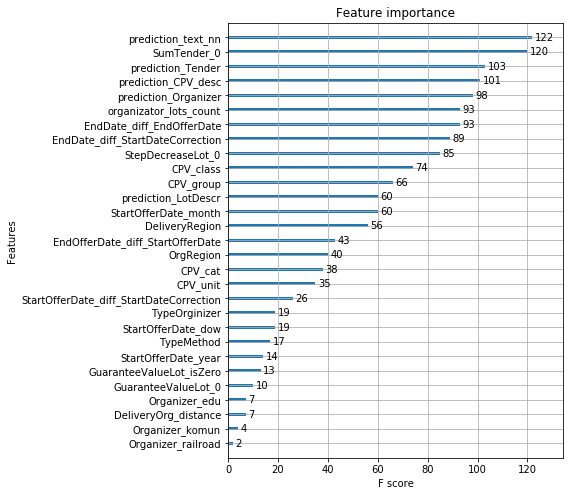

In [36]:
my_plot_importance(model, (6,8))

In [37]:
# seeds = [0, 42, 128]

# predictions = []
# predictions_subm = []
# for seed in seeds:
#     XGB_PARAMS['seed'] = seed
#     model = train_xgb_regressor(x_train, x_test, y_train, y_test)
#     rms = sqrt(mean_squared_error(y_test, model.predict(xgb.DMatrix(x_test))))
#     predictions.append(model.predict(xgb.DMatrix(x_test)))
#     predictions_subm.append(model.predict(xgb.DMatrix(df_test[features])))

In [38]:
# np.array(predictions_subm).shape

In [39]:
# rmsle(y_test, np.array(predictions).mean(axis=0))

In [40]:
X = pd.concat([x_train, x_test])
y = pd.concat([y_train, y_test])
dtrain = xgb.DMatrix(X, y)

# Uncomment to tune XGB `num_boost_rounds`
model_all = xgb.train(params=XGB_PARAMS, dtrain=dtrain,
                  num_boost_round=60)

In [41]:
# np.array(predictions_subm).mean(axis=0)

In [45]:
# final_preds = model.predict(xgb.DMatrix(df_test[features]))
final_preds_all = model_all.predict(xgb.DMatrix(df_test[features]))

In [46]:
# df_test['target'] = np.exp(final_preds) - 1
df_test_all = df_test
df_test_all['target'] = np.exp(final_preds_all) - 1
# df_test_3seeds = df_test

In [ ]:
# df_test_3seeds['target'] = np.exp(np.array(predictions_subm).mean(axis=0)) - 1

In [ ]:
# df_test[['unique_id','target']].to_csv('xgb_0_30.csv', index=False)
df_test_all[['unique_id','target']].to_csv('xgb_all_0_30.csv', index=False)
# df_test_3seeds[['unique_id','target']].to_csv('xgb_3_seeds.csv', index=False)

In [ ]:
pd.read_csv('xgb_all_0_30.csv').head()

In [ ]:
pd.read_csv('xgb_all_0_30.csv').head()